In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce
from scipy.signal import argrelextrema
from scipy.signal import argrelmin
import plotly
plotly.tools.set_credentials_file(username='IrisRuider', api_key='6sAyu3cCCvGM7uLvhxtH')
from plotly.graph_objs import Scatter, Figure, Layout
import plotly.plotly as py
import plotly.tools as tls
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import peakutils
import math
from sklearn.neighbors import KernelDensity

print (__version__ )# requires version >= 1.9.0
init_notebook_mode(connected=True)

2.5.1


In [2]:
 def smoothListGaussian(list,strippedXs=False,degree=5):  

     window=degree*2-1  

     weight=np.array([1.0]*window)  

     weightGauss=[]  

     for i in range(window):  

         i=i-degree+1  

         frac=i/float(window)  

         gauss=1/(np.exp((4*(frac))**2))  

         weightGauss.append(gauss)  

     weight=np.array(weightGauss)*weight  

     smoothed=[0.0]*(len(list)-window)  

     for i in range(len(smoothed)):  

         smoothed[i]=sum(np.array(list[i:i+window])*weight)/sum(weight)  

     return smoothed

In [3]:
def get_width (xcorr, pos_peak):
    
    width = []
    
    for element in pos_peak:
        
        width.append(xcorr[element[1]]-xcorr[element[0]])
    
    return width
        

In [4]:
def get_background (signal, pos_peak):
    
    if len(pos_peak)!=0:
    
        ind2remove = []

        for element in pos_peak:

            ind2remove.append(list(range(element[0], element[1]+1 )))

        signal = [x for i,x in enumerate(signal) if i not in reduce(lambda x,y: x+y,ind2remove)]


        return np.mean(signal)
    else: return None 


In [5]:
def get_height (signal, pos_max, bg):
    
    height = []
    
    for element in pos_max:
        
        height.append(signal[element] - bg)
    
    return height

In [6]:
def interpolation (x1, x2, y1, y2):
 
    m = (y2-y1)/(x2-x1)
    t = y1 - x1*m
    x = (1-t)/m
    
    return x

In [7]:
def silverman_estimate(arr):
    """silverman estimate for the optimal bandwith for KDE"""
    return ( (4.0*np.std(arr)**5.0 ) / (3.0*arr.size) )**(0.2)

In [8]:
def kde_hg(X_, X_plot_,kde_kernel, bandwidth,rtol=1.0e-2):
    #X: sequence to be fitted, > 1 numbers, please (eg nm)
    #X_plot: resulting pdf will be plotted over this range
    #kde_kernel, bandwidth = type of kernel, smoothing parameter
    X = X_[:,np.newaxis]
    X_plot = X_plot_[:, np.newaxis]
    kde = KernelDensity(kernel=kde_kernel, bandwidth=bandwidth, rtol=rtol).fit(X)
    zzz = np.exp( kde.score_samples(X_plot) )
    #zzz = np.exp(log_dens)
    return zzz

In [9]:
#Fonction
#Parameters: data
#Returns: KDE value
def KDE (loading_rates):
    kde_kernel="gaussian"
    rup_bins = np.linspace(np.min(loading_rates),np.amax(loading_rates),num=100)

    #print rup_bins

    silverman = np.abs(silverman_estimate(loading_rates)*1.0)
    if silverman == 0.0:
        silverman = 1.0
    pdf = kde_hg(loading_rates, rup_bins ,kde_kernel,silverman)
    pdf /= np.max(pdf)
    maximum = np.argmax(pdf)

    bins=np.arange(min(loading_rates), max(loading_rates) + 50, 5)

    #print bins

    #n, bins, patches = plt.hist(data[:,3], bins = bins)

    hist, bin_edges = np.histogram(loading_rates, bins = bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [3, 680, 4]
    #p0 =[2.88914398e+01,   6.25377579e-08,   1.87780086e-08]

    #me: coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

    # calculate mean loading rate
    avg_loadrate = np.mean(loading_rates)

    # Get the fitted curve
    #me: hist_fit = gauss(bin_centres, *coeff)

    plt.title('Loading rate histogram')
    plt.axvline(rup_bins[maximum], lw=2, color='green', alpha=.5, ls=':',label='Silverman KDE Max: %s' %rup_bins[maximum])
    #plt.axvline(bin_centres[np.argmax(hist_fit)], lw=2, color='red', alpha=.5, ls=':',label='Gaussian Max: %s' %bin_centres[np.argmax(hist_fit)])
    plt.axvline(avg_loadrate, lw=2, color='b', alpha=.5, ls=':',label='Mean: %s' %avg_loadrate)

    hist = np.array(hist, dtype=float)/max(hist)

    plt.bar(bin_centres, hist,width=5,alpha=.5,label="histogram")
    #plt.plot(bin_centres, hist_fit/max(hist_fit), color = "red",label= "gaussian fit")
    plt.plot(rup_bins,pdf, lw=3, color='k', label='silverman')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.xlabel("Loading rate [pN/s]")
    plt.ylabel("au")

    plt.show()
    
    return rup_bins[maximum]

In [69]:
#Fonction
#Parameters: data
#Returns: KDE value
def KDE1 (loading_rates, w, xlabel, save_path = None):
    import matplotlib
    from matplotlib import rcParams
    matplotlib.use('TkAgg')
    kde_kernel="gaussian"
    rup_bins = np.linspace(np.min(loading_rates),np.amax(loading_rates),num=100)

    #print rup_bins

    silverman = np.abs(silverman_estimate(loading_rates)*1.0)
    if silverman == 0.0:
        silverman = 1.0
    pdf = kde_hg(loading_rates, rup_bins ,kde_kernel,silverman)
    pdf /= np.max(pdf)
    maximum = np.argmax(pdf)

    bins=np.arange(min(loading_rates), max(loading_rates) + 50, 5)

    #print bins

    #n, bins, patches = plt.hist(data[:,3], bins = bins)

    hist, bin_edges = np.histogram(loading_rates, bins = 10)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [3, 680, 4]
    #p0 =[2.88914398e+01,   6.25377579e-08,   1.87780086e-08]

    #me: coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

    # calculate mean loading rate
    avg_loadrate = np.mean(loading_rates)
    avg_error = np.std(loading_rates)/math.sqrt(len(loading_rates)-1)

    # Get the fitted curve
    #me: hist_fit = gauss(bin_centres, *coeff)
    
    a = argrelmin(abs(pdf-0.5))
    error = np.array([])
    for element in a:
        error = np.append(error, abs(rup_bins[maximum]-rup_bins[element]))
        
    #'-'+repr(round(error[0],2))+'+'+repr(round(error[1],2))
    plt.title('Loading rate histogram')
    plt.axvline(rup_bins[maximum], lw=4, color='green', alpha=.5, ls=':',label='Silverman KDE Max: %s' %format(rup_bins[maximum], '.2f')+ '-'+format(error[0],'.2f')+'+'+format(error[1],'.2f'))
    #plt.axvline(bin_centres[np.argmax(hist_fit)], lw=2, color='red', alpha=.5, ls=':',label='Gaussian Max: %s' %bin_centres[np.argmax(hist_fit)])
    plt.axvline(avg_loadrate, lw=2, color='b', alpha=.5, ls=':',label='Mean: %s' %format(avg_loadrate, '.2f'))

    hist = np.array(hist, dtype=float)/max(hist)

    plt.bar(bin_centres, hist,width=w,alpha=.5,label="histogram")
    #plt.plot(bin_centres, hist_fit/max(hist_fit), color = "red",label= "gaussian fit")
    plt.plot(rup_bins,pdf, lw=3, color='k', label='silverman')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.xlabel(xlabel)
    plt.ylabel("[a.u]")
    
    if save_path != None:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()
    return rup_bins[maximum]



C:\Users\Iris Ruider\Documents\EPFL\2017_18\Semestre_2\Laboratoire\iris\alpha-Syn\20d
im here
and here
180406Height 4.0x4.0 003_Line_slanted(1).txt


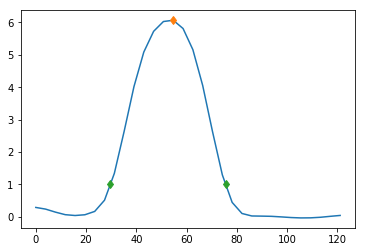

im here
and here
180406Height 4.0x4.0 003_Line_slanted(10).txt


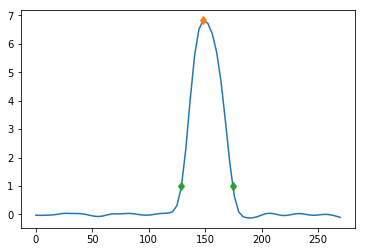

im here
and here
180406Height 4.0x4.0 003_Line_slanted(2).txt


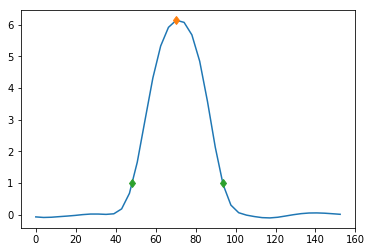

im here
and here
180406Height 4.0x4.0 003_Line_slanted(3).txt


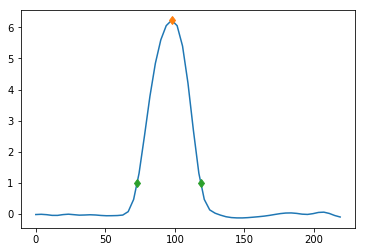

im here
and here
180406Height 4.0x4.0 003_Line_slanted(4).txt


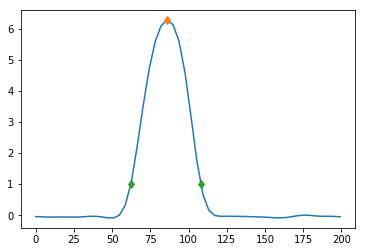

im here
and here
180406Height 4.0x4.0 003_Line_slanted(5).txt


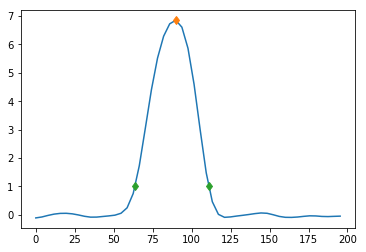

im here
and here
180406Height 4.0x4.0 003_Line_slanted(6).txt


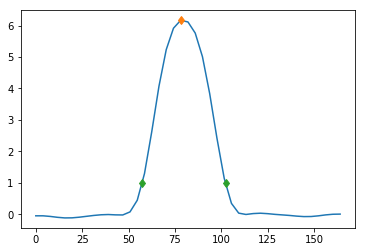

im here
and here
180406Height 4.0x4.0 003_Line_slanted(7).txt


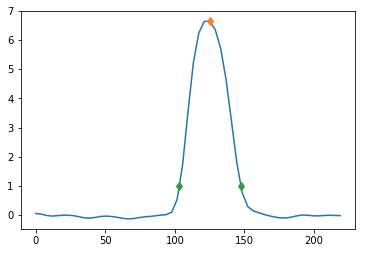

im here
and here
180406Height 4.0x4.0 003_Line_slanted(8).txt


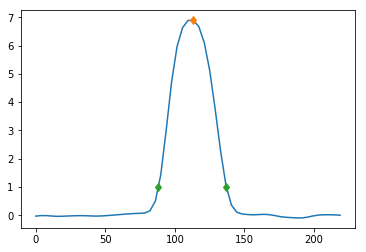

im here
and here
180406Height 4.0x4.0 003_Line_slanted(9).txt


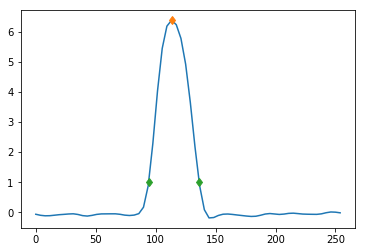

im here
and here
180406Height 4.0x4.0 003_Line_slanted.txt


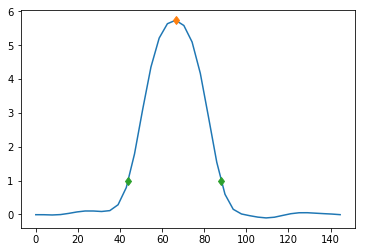

im here
and here
180406Height 4.0x4.0 004_Line_slanted(1).txt


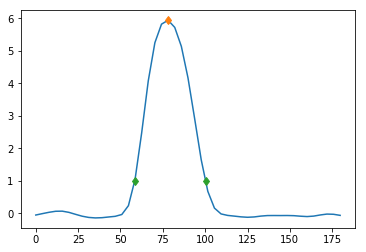

im here
and here
180406Height 4.0x4.0 004_Line_slanted(2).txt


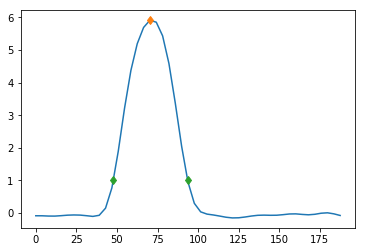

im here
and here
180406Height 4.0x4.0 004_Line_slanted(3).txt


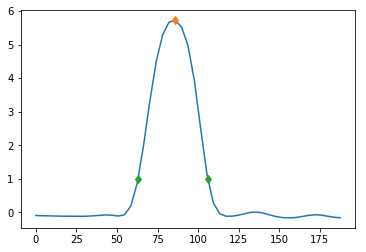

im here
and here
180406Height 4.0x4.0 004_Line_slanted(4).txt


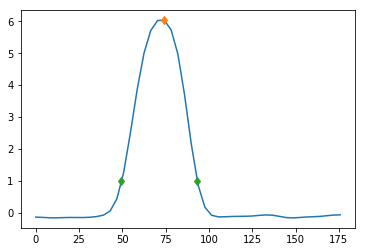

im here
and here
180406Height 4.0x4.0 004_Line_slanted(5).txt


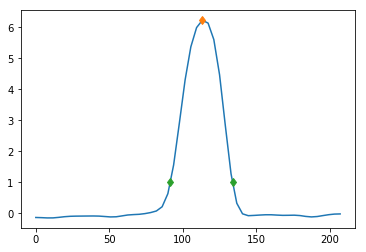

im here
and here
180406Height 4.0x4.0 004_Line_slanted(6).txt


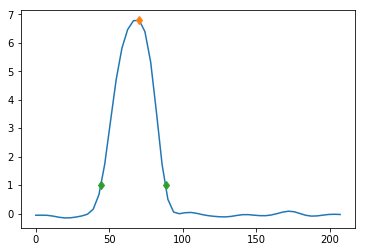

im here
and here
180406Height 4.0x4.0 004_Line_slanted.txt


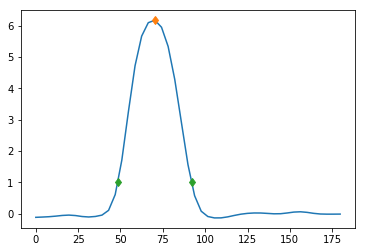

im here
and here
180406Height 4.0x4.0 005_Line_slanted(1).txt


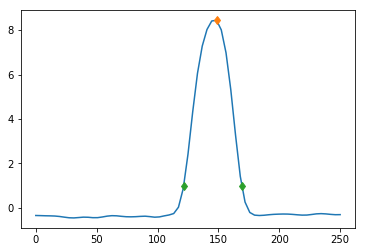

im here
and here
180406Height 4.0x4.0 005_Line_slanted(2).txt


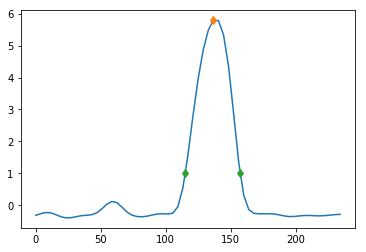

im here
and here
180406Height 4.0x4.0 005_Line_slanted(3).txt


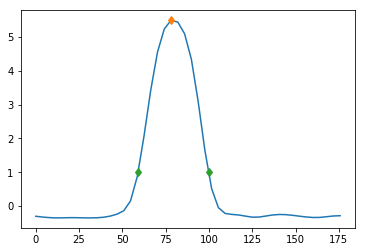

im here
and here
180406Height 4.0x4.0 005_Line_slanted(4).txt


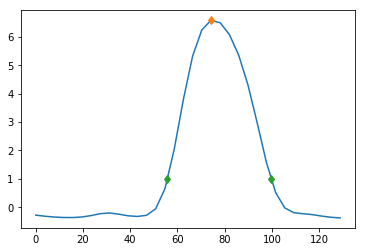

im here
and here
180406Height 4.0x4.0 005_Line_slanted(5).txt


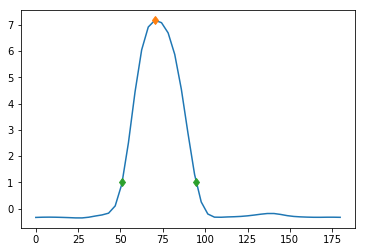

im here
and here
im here
and here
180406Height 4.0x4.0 005_Line_slanted(6).txt


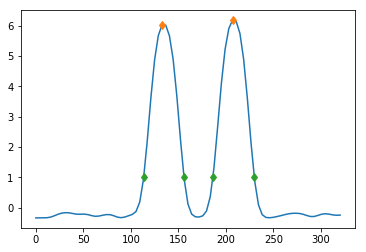

im here
and here
180406Height 4.0x4.0 005_Line_slanted(7).txt


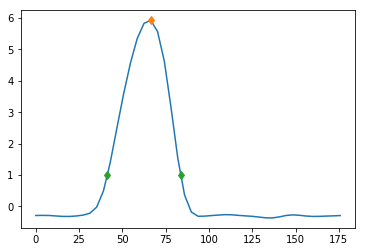

im here
and here
180406Height 4.0x4.0 005_Line_slanted(8).txt


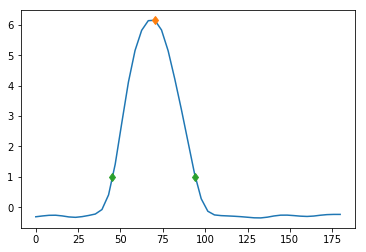

im here
and here
180406Height 4.0x4.0 005_Line_slanted.txt


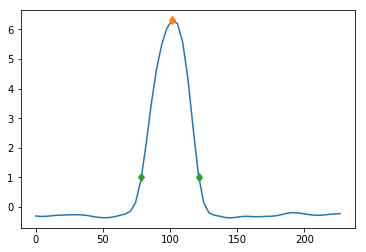

im here
and here
180406Height 4.0x4.0 007_Line_slanted(1).txt


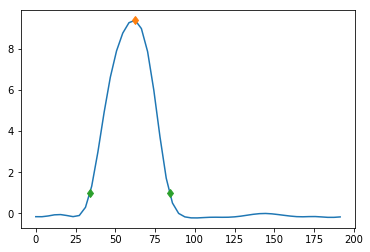

im here
and here
180406Height 4.0x4.0 007_Line_slanted(10).txt


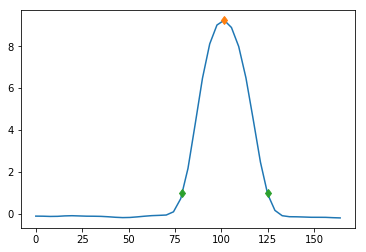

im here
and here
180406Height 4.0x4.0 007_Line_slanted(11).txt


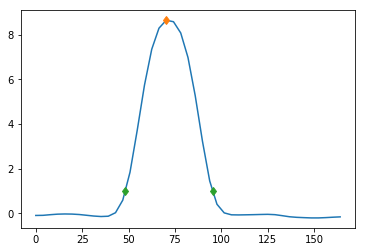

im here
and here
180406Height 4.0x4.0 007_Line_slanted(12).txt


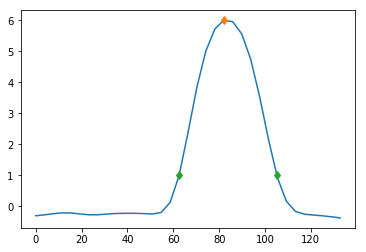

im here
and here
180406Height 4.0x4.0 007_Line_slanted(13).txt


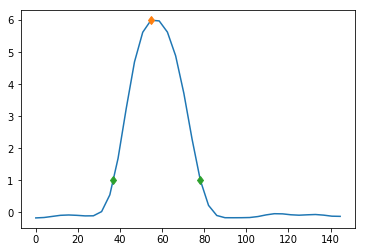

im here
and here
180406Height 4.0x4.0 007_Line_slanted(2).txt


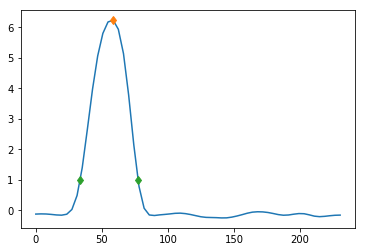

im here
and here
180406Height 4.0x4.0 007_Line_slanted(3).txt


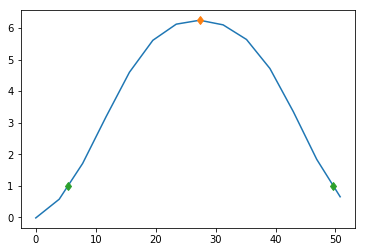

im here
and here
180406Height 4.0x4.0 007_Line_slanted(4).txt


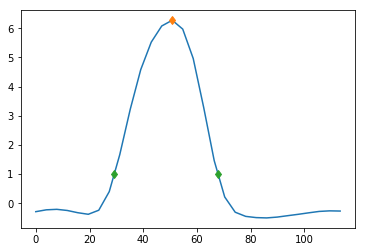

im here
and here
180406Height 4.0x4.0 007_Line_slanted(5).txt


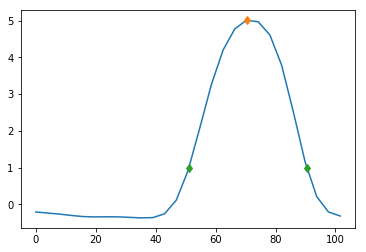

im here
and here
180406Height 4.0x4.0 007_Line_slanted(6).txt


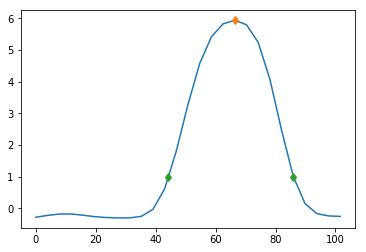

im here
and here
180406Height 4.0x4.0 007_Line_slanted(7).txt


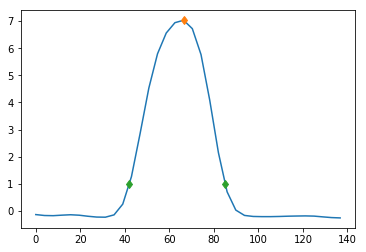

im here
and here
180406Height 4.0x4.0 007_Line_slanted(8).txt


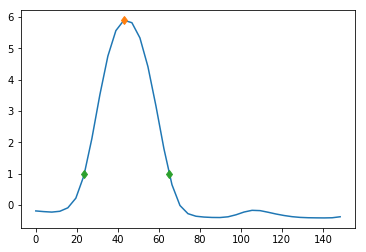

im here
and here
180406Height 4.0x4.0 007_Line_slanted.txt


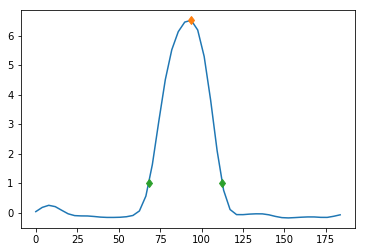

im here
and here
180406Height 4.0x4.0 008_Line_slanted(1).txt


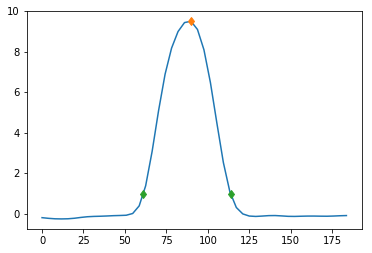

im here
and here
180406Height 4.0x4.0 008_Line_slanted(10).txt


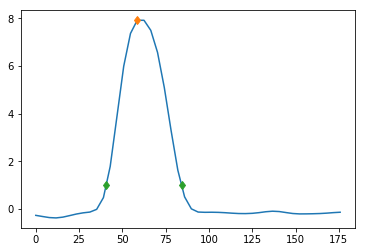

im here
and here
180406Height 4.0x4.0 008_Line_slanted(11).txt


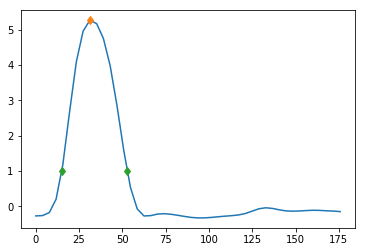

im here
and here
180406Height 4.0x4.0 008_Line_slanted(12).txt


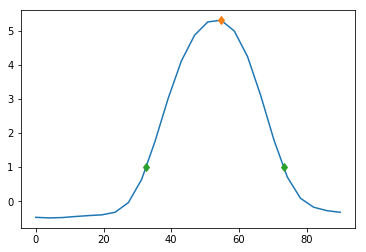

im here
and here
180406Height 4.0x4.0 008_Line_slanted(13).txt


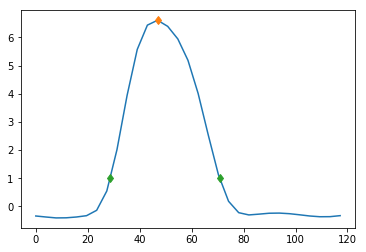

im here
im here
and here
180406Height 4.0x4.0 008_Line_slanted(15).txt


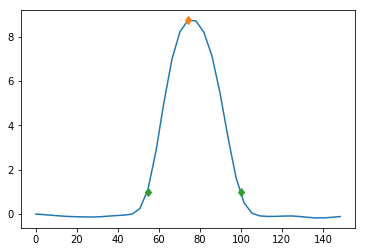

im here
and here
180406Height 4.0x4.0 008_Line_slanted(16).txt


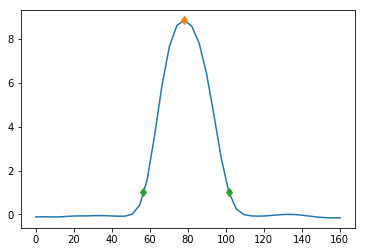

im here
and here
180406Height 4.0x4.0 008_Line_slanted(2).txt


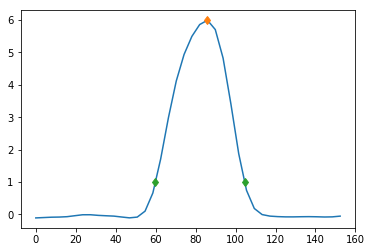

im here
and here
180406Height 4.0x4.0 008_Line_slanted(3).txt


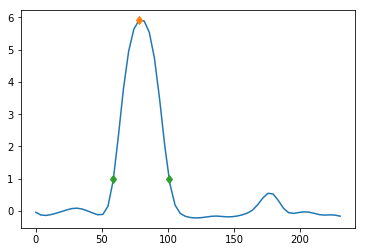

im here
and here
180406Height 4.0x4.0 008_Line_slanted(5).txt


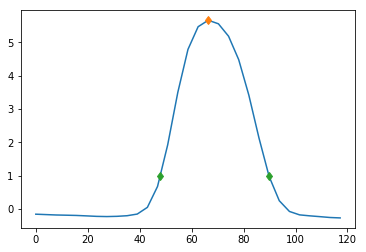

im here
and here
180406Height 4.0x4.0 008_Line_slanted(6).txt


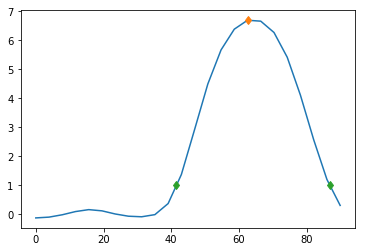

im here
and here
180406Height 4.0x4.0 008_Line_slanted(7).txt


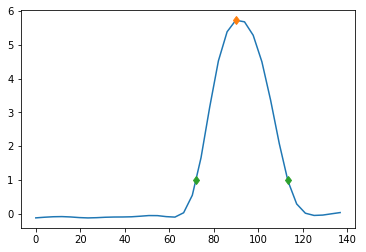

im here
and here
180406Height 4.0x4.0 008_Line_slanted(8).txt


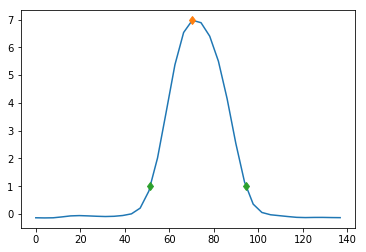

im here
and here
180406Height 4.0x4.0 008_Line_slanted(9).txt


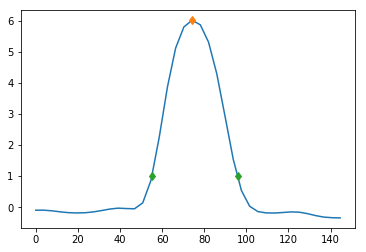

im here
and here
180406Height 4.0x4.0 008_Line_slanted.txt


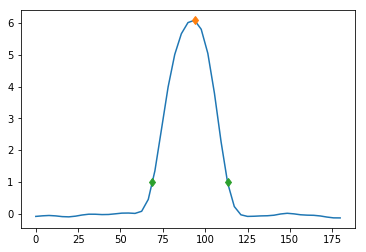

im here
and here
180406Height 4.0x4.0 009_Line_slanted(1).txt


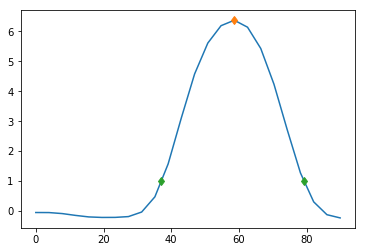

im here
and here
180406Height 4.0x4.0 009_Line_slanted(10).txt


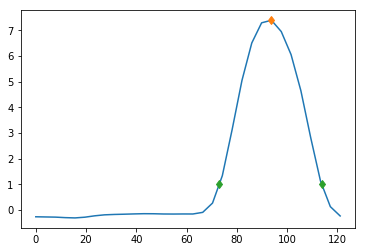

im here
im here
and here
180406Height 4.0x4.0 009_Line_slanted(12).txt


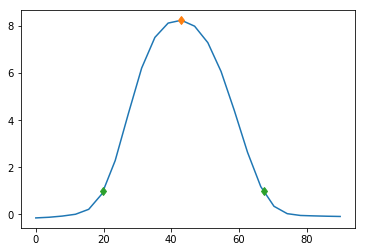

im here
and here
180406Height 4.0x4.0 009_Line_slanted(13).txt


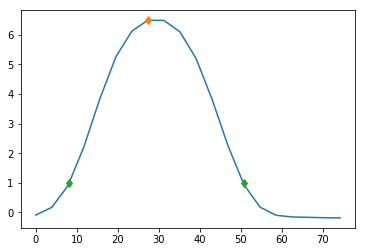

im here
and here
180406Height 4.0x4.0 009_Line_slanted(14).txt


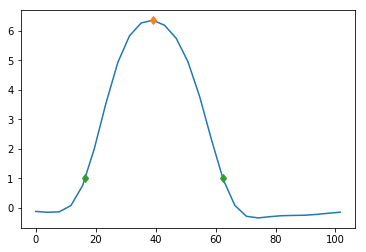

im here
and here
180406Height 4.0x4.0 009_Line_slanted(15).txt


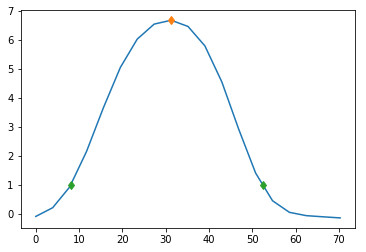

im here
and here
180406Height 4.0x4.0 009_Line_slanted(16).txt


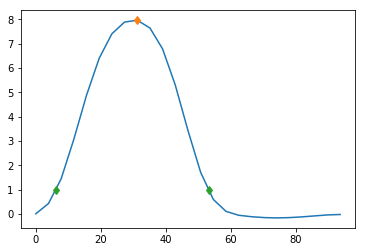

im here
and here
180406Height 4.0x4.0 009_Line_slanted(17).txt


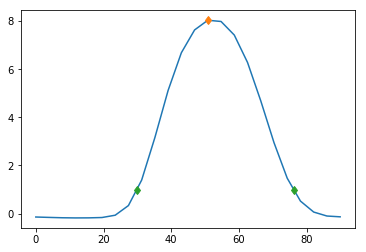

im here
and here
180406Height 4.0x4.0 009_Line_slanted(19).txt


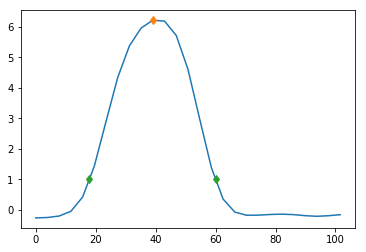

im here
and here
180406Height 4.0x4.0 009_Line_slanted(2).txt


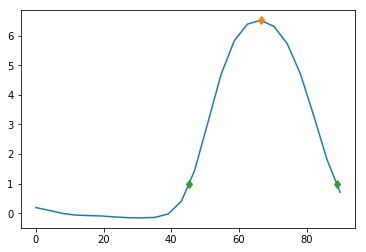

im here
and here
180406Height 4.0x4.0 009_Line_slanted(20).txt


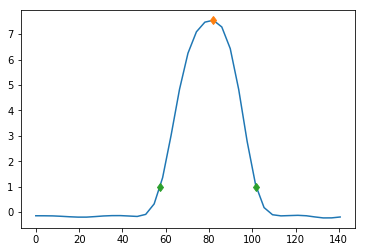

im here
and here
180406Height 4.0x4.0 009_Line_slanted(21).txt


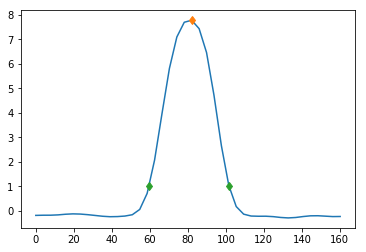

im here
and here
180406Height 4.0x4.0 009_Line_slanted(22).txt


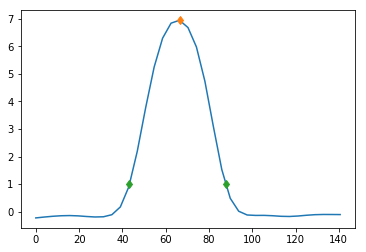

im here
and here
180406Height 4.0x4.0 009_Line_slanted(23).txt


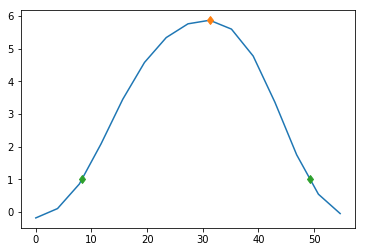

im here
im here
and here
180406Height 4.0x4.0 009_Line_slanted(25).txt


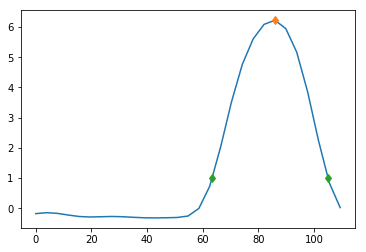

im here
and here
180406Height 4.0x4.0 009_Line_slanted(26).txt


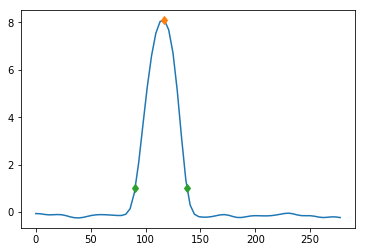

im here
and here
180406Height 4.0x4.0 009_Line_slanted(27).txt


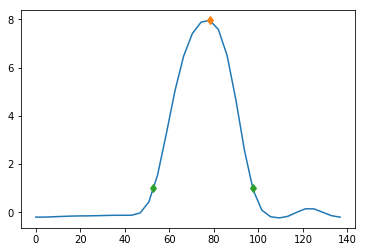

im here
and here
180406Height 4.0x4.0 009_Line_slanted(3).txt


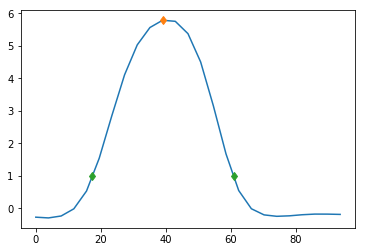

im here
and here
180406Height 4.0x4.0 009_Line_slanted(4).txt


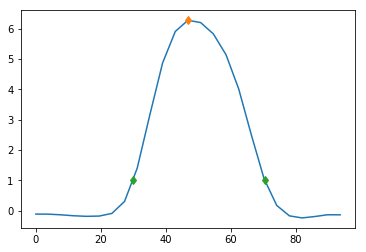

im here
and here
180406Height 4.0x4.0 009_Line_slanted(6).txt


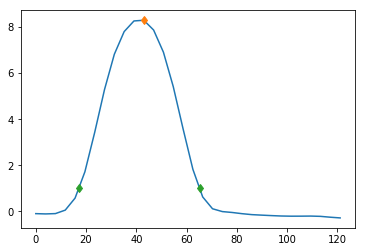

im here
and here
180406Height 4.0x4.0 009_Line_slanted(7).txt


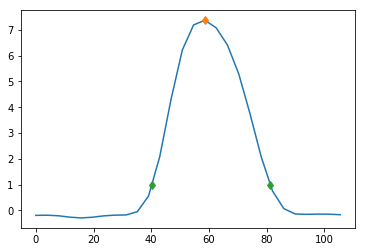

im here
and here
180406Height 4.0x4.0 009_Line_slanted(8).txt


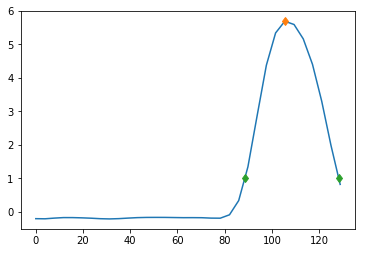

im here
and here
180406Height 4.0x4.0 009_Line_slanted(9).txt


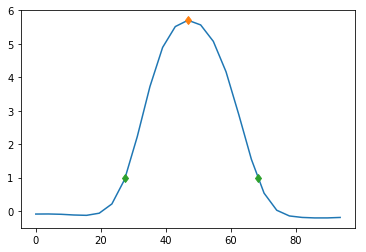

im here
and here
180406Height 4.0x4.0 009_Line_slanted.txt


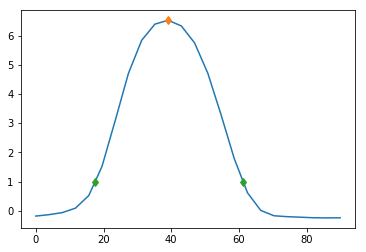

im here
and here
180406Height 4.0x4.0 010_Line_slanted(1).txt


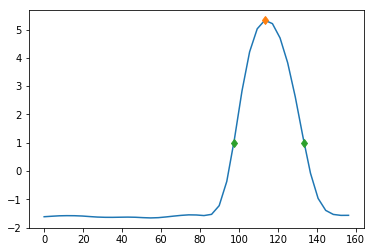

im here
and here
180406Height 4.0x4.0 010_Line_slanted.txt


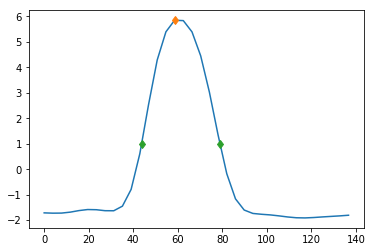

In [11]:
#get path to current folder
#dir_path = cwd = os.getcwd()
dir_path = r'C:\Users\Iris Ruider\Documents\EPFL\2017_18\Semestre_2\Laboratoire\iris\alpha-Syn\20d'
print(dir_path)
filenames = os.listdir(dir_path)
hist_width = []
hist_height = []

for file in filenames:
    if "txt" in file:
        path_to_file = os.path.join(dir_path, file)
        fd = open(path_to_file , 'r')
        try: 

            x = []
            y = []
            for index,line in enumerate(fd):
                if index > 3:
                        data = line.split('	')
                        x.append(float(data[0]))
                        y.append(float(data[1]))
        finally:
            fd.close()

        #smooth the data with Gaussian filter
        #define width of window
        window = 4
        s = smoothListGaussian(y, degree = window)


        #search local maximass in signal
        ymax = peakutils.indexes(s)
        #let run a loop on signal do detect how man single fibers are in signal
        maximum = False
        start = 0
        stop = 0
        #Define criterion when you can consider sth a fiber
        average_min = 3
        min_val = 1

        #we want to stor the index of where the peak starts and where the maw are that correspond to fibers
        index_peak = []
        index_max = []
        width = []
        pos_peak = []


        for index, element in enumerate(s):

            if element>min_val and maximum == False:
                start = index
                maximum = True

            if maximum == True and element <min_val:
                stop = index
                maximum = False

                if np.mean(s[start:stop]) > average_min:
                    if not (s[start] < 1.1 and s [start] > 0.9):
                        if s[start] > 1:
                            x_start = interpolation(x[start-1], x[start], s[start-1], s[start])
                            start = start - 1
                        else:
                            x_start = interpolation(x[start], x[start+1], s[start], s[start+1])
                    else:
                        x_start = x[start]
                    
                    if not(s[stop] < 1.1 and s [stop] > 0.9):
                        if s[stop] > 1:
                            x_stop = interpolation(x[stop], x[stop+1], s[stop], s[stop+1])
                            stop = stop + 1
                        else:
                            x_stop = interpolation(x[stop-1], x[stop], s[stop-1], s[stop])
                    else:
                        x_stop = x[stop]
                    print("im here")
                            
                    if start >= 0 and stop >=0: 
                        print("and here")
                        index_peak.append([start, stop])
                        index_max.append([i for i in ymax if i >= start and i <= stop])
                        width.append(x_stop-x_start)
                        pos_peak.append([x_start, x_stop])

        bg = get_background(s, index_peak)
        if len(index_max)!=0:
            
            print(file)
            
            hist_width.append(width)
            hist_height.append(get_height(y,reduce(lambda x,y: x+y,index_max),bg))

            plt.plot(x[:-2*window+1],s)
            plt.plot(x[:-2*window+1],s,markevery=reduce(lambda x,y: x+y,index_max), ls="", marker="d", label="points")
            plt.plot(reduce(lambda x,y: x+y,pos_peak),np.ones(len(reduce(lambda x,y: x+y,pos_peak))), ls="", marker="d", label="points")
            plt.show()

C:\Users\Iris Ruider\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:


This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\Iris Ruider\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Iris Ruider\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Iris Ruider\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Iris Ruider\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Iris Ruider\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_

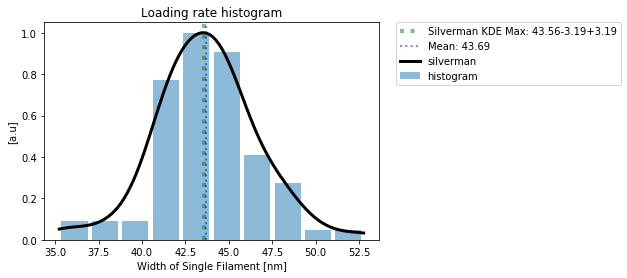

43.5567481518


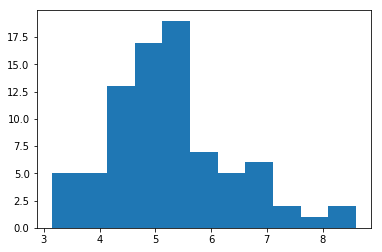

In [70]:
from scipy import stats
hw = reduce(lambda x,y: x+y,hist_width)
hh = reduce(lambda x,y: x+y,hist_height)
w_1f = KDE1(np.array(hw), 1.5, "Width of Single Filament [nm]", r'C:\Users\Iris Ruider\Documents\EPFL\2017_18\Semestre_2\Laboratoire\iris\alpha-Syn\20d\Test.eps')
print(w_1f)
h_1f = 
plt.show(np.array(hh), 0.5, "Height of Single Filament [nm]")

In [ ]:
iplot([{'x': x[:-2*window+1], 'y': s}])
plt.plot(x[:-2*window+1],s,markevery=reduce(lambda x,y: x+y,index_max), ls="", marker="d", label="points")
indexes = peakutils.indexes(x, thres=1)
print (indexes)

#plot_url = py.plot_mpl(plotly_fig, filename='mpl-axes-labels')

#plot_url = py.plot_mpl(plotly_fig, filename='mpl-annotation-with-custom-font-size')

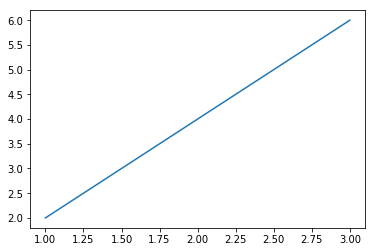

In [58]:
a = [1, 2, 3]
b = [2, 4, 6]
plt.plot(a,b)
plt.savefig(r'C:\Users\Iris Ruider\Documents\EPFL\2017_18\Semestre_2\Laboratoire\iris\alpha-Syn\20d\Test.eps')


In [ ]:
path_to_file = os.path.join(dir_path, 'test.txt')
fd = open(path_to_file , 'r')
try: 

    x = []
    y = []
    for index,line in enumerate(fd):
        if index > 3:
                data = line.split('	')
                x.append(float(data[0]))
                y.append(float(data[1]))
finally:
    fd.close()

#smooth the data with Gaussian filter
#define width of window
window = 3
s = smoothListGaussian(y, degree = window)


#search local maximass in signal
ymax = peakutils.indexes(s)
print(ymax)
#let run a loop on signal do detect how man single fibers are in signal
maximum = False
start = 0
stop = 0
#Define criterion when you can consider sth a fiber
average_min = 3
min_val = 1

#we want to stor the index of where the peak starts and where the maw are that correspond to fibers
index_peak = []
index_max = []


for index, element in enumerate(s):

    if element>min_val and maximum == False:
        start = index
        maximum = True

    if maximum == True and element <min_val:
        stop = index
        maximum = False

        if np.mean(s[start:stop]) > average_min:
            index_peak.append([start, stop])
            index_max.append([i for i in ymax if i >= start and i <= stop])

bg = get_background(s, index_peak)
if len(index_max)!=0:

    hist_width.append(get_width(x, index_peak))
    hist_height.append(get_height(y,reduce(lambda x,y: x+y,index_max),bg))

    plt.plot(x[:-2*window+1],s)
    plt.plot(x[:-2*window+1],s,markevery=reduce(lambda x,y: x+y,index_max), ls="", marker="d", label="points")
    plt.plot(x[:-2*window+1],s,markevery=reduce(lambda x,y: x+y,index_peak), ls="", marker="s", label="points")
    plt.show()